In [1]:
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from transvae import trans_models
from transvae.transformer_models import TransVAE
from transvae.rnn_models import RNN, RNNAttn
from transvae.wae_models import WAE
from transvae.aae_models import AAE
from transvae.tvae_util import *
from transvae import analysis

In [2]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

import IPython.display as Disp
np.set_printoptions(suppress=True)

This tutorial will demonstrate how to visualize and interpret model memory and how to evaluate model performance on a number of metrics. Full scripts for training models, generating samples and calculating attention weights are provided and instructions on how to use those scripts are included in the README. The functions demonstrated in this tutorial do not have pre-written high throughput scripts but can be used on larger input sizes if desired. 

# Model Reconstruction Performance

A set of metrics on reconstruction accuracy of the different models is presented below. Some parameters need to be selected:
<ul>
    <li>data size: int --how many samples from the data to laod
    <li>data selection: string  --training, testing, full_no_shuffle
    <li>model_src: string --path to model checkpoint
    <li>models : RNN, WAE, AAE, RNNAttn, TransVAE --model selectiong from listed
</ul>

In [3]:
num_sequences =1000
data_selection = "sunistar"
model_src = "checkpointz/amp_aae//sunistar_emb128_latent64_pp//300_aae-128_peptide.ckpt"
src = 'checkpointz//amp_aae//sunistar_emb128_latent64_pp//log_aae-128_peptide.txt' #src of the loss output file
model = AAE(load_fn=model_src)

save_dir= "model_analyses//"+model.name+"_latent128_sunistar_pp_test" #each model will have its own directory
if not os.path.exists(save_dir):os.mkdir(save_dir) 
save_dir= save_dir+"//" #actually enter the folder that was created above

save_df = pd.DataFrame() #this will hold the number variables and save to CSV

gpu = True

if "full_no_shuffle" in data_selection:
    data = pd.read_csv('notebooks//example_data//peptide_combined_no_shuff.txt').to_numpy() 
elif "training" in data_selection:
    data = pd.read_csv('notebooks//example_data//train_test//peptide_train.txt').to_numpy()
elif "testing" in data_selection:
    data = pd.read_csv('notebooks//example_data//train_test//peptide_test.txt').to_numpy()
else:
    data = pd.read_csv('data//example_data//sunistar//peptide_test.txt').to_numpy() 
data_1D = data[:num_sequences,0] #gets rid of extra dimension

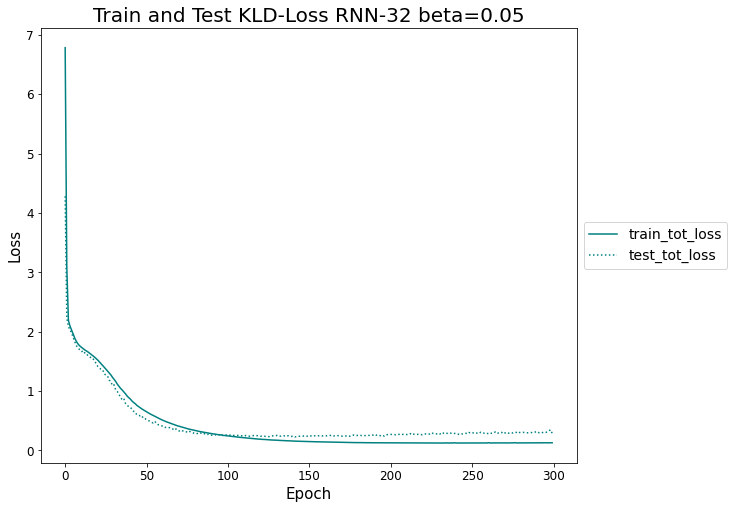

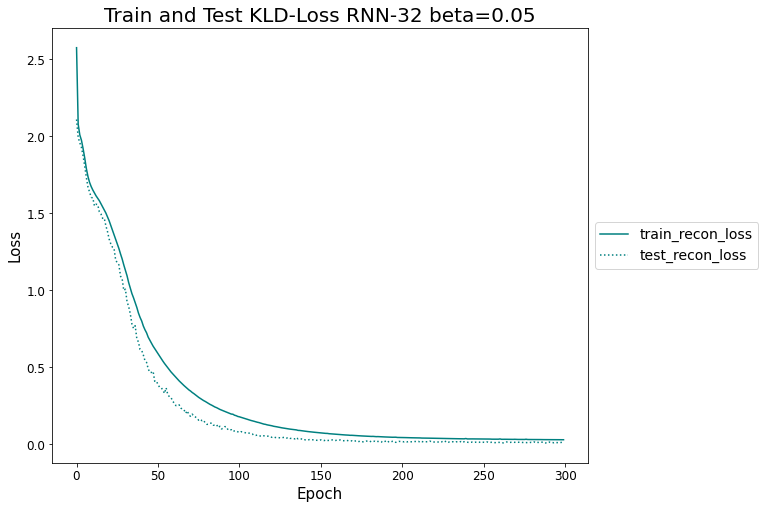

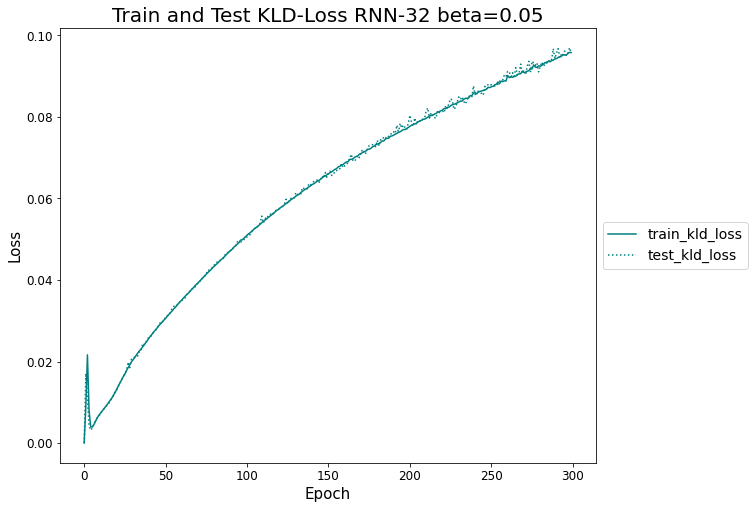

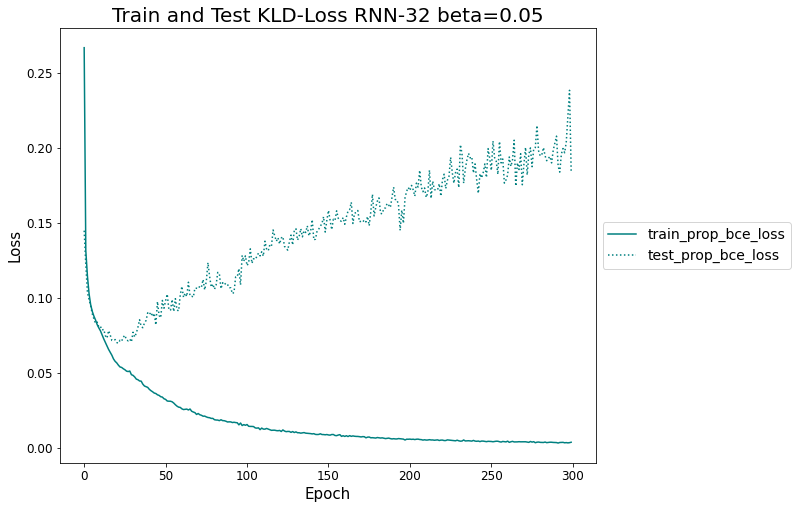

In [4]:
tot_loss = analysis.plot_loss_by_type(src,loss_types=['tot_loss'])
plt.savefig(save_dir+'tot_loss.png',dpi=200)
recon_loss = analysis.plot_loss_by_type(src,loss_types=['recon_loss'])
plt.savefig(save_dir+'recon_loss.png',dpi=200)
kld_loss = analysis.plot_loss_by_type(src,loss_types=['kld_loss'])

plt.savefig(save_dir+'kld_loss.png',dpi=200)
prob_bce_loss = analysis.plot_loss_by_type(src,loss_types=['prop_bce_loss'])
plt.savefig(save_dir+'prob_bce_loss.png',dpi=200)
if 'aae' in src:
    disc_loss = analysis.plot_loss_by_type(src,loss_types=['disc_loss'])
    plt.savefig(save_dir+'disc_loss.png',dpi=200)
if 'wae' in src:
    mmd_loss = analysis.plot_loss_by_type(src,loss_types=['mmd_loss'])
    plt.savefig(save_dir+'mmd_loss.png',dpi=200)

In [23]:
LOAD=False
if LOAD: #this allows loading of reconstructed sequences from a file to save time
    recon_src = 'slurm_analyses//rnn-128_peptide_latent_32//saved_info.csv'
    recon_df = pd.read_csv(recon_src)
    reconstructed_seq = recon_df['reconstructions'].to_list()[:num_sequences]
    props = torch.Tensor(recon_df['predicted properties'][:num_sequences])
else:
    model.params['BATCH_SIZE'] = 200 #batch size must match total size of input data
    reconstructed_seq, props = model.reconstruct(data[:num_sequences], log=False, return_mems=False)
    for og_token, reconstructed_token in zip(data_1D, reconstructed_seq):
        print('{} <- Original'.format(og_token))
        print('{} <- Reconstruction'.format(reconstructed_token))
        print('\n')

trans1x-128_peptide
cuda
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
cuda
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
cuda
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
cuda
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
cuda
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
MNVGVCYAEVDRQLWMRLEVPDSSTIEEAINLSGVL <- Original
HHHHHHTKRRITPKDVIDVRSVTTEINT <- Reconstruction


MLLLLSCGYHGGSPVNTGRCIVHKRQTGFTLIELMIVVA <- Original
MLRALRGEGYHHITVAGKEDAPCDHVYDVTGSLCENNDKFAVDR <- Reconstruction


MTWMHPYWIC <- Original
MADTDLFM <- Reconstruction


CPCQGLDVPFQAFWVKCWMPGLLSHT <- Original
RTFGAKPPNIPFPRR <- Reconstruction


MLDMVHLSQHQEE

In [6]:
# training = pd.read_csv('notebooks//example_data//train_test//peptide_train.txt').to_numpy()
# train_idx_list = [np.where(data==training[idx][0]) for idx in range(len(training))]

# testing = pd.read_csv('notebooks//example_data//train_test//peptide_test.txt').to_numpy()
# test_idx_list = [np.where(data==testing[idx][0]) for idx in range(len(testing))]

In [7]:
# test=True
# train=False
# if test:
#     batch_recon_len = len(reconstructed_seq)
#     reconstructed_seq = [reconstructed_seq[test_idx_list[i][0][0]] for i in range(len(test_idx_list)) if test_idx_list[i][0][0]<batch_recon_len]
#     data_1D= [data_1D[test_idx_list[i][0][0]] for i in range(len(test_idx_list)) if test_idx_list[i][0][0]<batch_recon_len]
#     props = [props[test_idx_list[i][0][0]] for i in range(len(test_idx_list)) if test_idx_list[i][0][0]<batch_recon_len]
#     props=torch.Tensor(props)
#     data = testing[:][0]
#     true_props_data = pd.read_csv('notebooks//example_data//function_full_no_shuff.txt').to_numpy()
#     true_props = true_props_data[0:num_sequences,0]
#     true_props= [true_props[test_idx_list[i][0][0]] for i in range(len(test_idx_list)) if test_idx_list[i][0][0]<batch_recon_len]
# if train:
#     batch_recon_len = len(reconstructed_seq)
#     reconstructed_seq = [reconstructed_seq[train_idx_list[i][0][0]] for i in range(len(train_idx_list)) if train_idx_list[i][0][0]<batch_recon_len]
#     data_1D= [data_1D[train_idx_list[i][0][0]] for i in range(len(train_idx_list)) if train_idx_list[i][0][0]<batch_recon_len]
#     props = [props[train_idx_list[i][0][0]] for i in range(len(train_idx_list)) if train_idx_list[i][0][0]<batch_recon_len]
#     props=torch.Tensor(props)
#     data = training[:][0]
#     true_props_data = pd.read_csv('notebooks//example_data//function_full_no_shuff.txt').to_numpy()
#     true_props = true_props_data[0:num_sequences,0]
#     true_props= [true_props[train_idx_list[i][0][0]] for i in range(len(train_idx_list)) if train_idx_list[i][0][0]<batch_recon_len]

In [8]:
# n_data_1D=[]
# n_reconstructed_seq=[]
# for idx,seq in enumerate(data_1D):
#     if len(seq)<50:
#         n_data_1D.append(seq)
#         n_reconstructed_seq.append(reconstructed_seq[idx])
# data_1D=n_data_1D
# reconstructed_seq=n_reconstructed_seq

In [24]:
if gpu:
    torch.cuda.empty_cache() #free allocated CUDA memory

In [25]:
save_df['reconstructions'] = reconstructed_seq #placing the saves on a line separate from the ops allows for editing
save_df['predicted properties'] = [prop.item() for prop in props[:len(reconstructed_seq)]]

ValueError: Length of values (1000) does not match length of index (128)

<ul>MCC info:
    <li>+1 represents a perfect prediction
    <li>0 no better than random prediction
    <li>−1 indicates total disagreement between prediction and observation.
</ul>

In [29]:
true_props_data = pd.read_csv('data//peptides//datasets//uniprot_v2//function_test.txt').to_numpy()
# true_props = true_props_data[0:num_sequences,0]
# prop_acc, prop_conf, MCC=calc_property_accuracies(props[:len(reconstructed_seq)],true_props[:len(reconstructed_seq)])

In [12]:
save_df['property prediction accuracy'] = prop_acc
save_df['property prediction confidence'] = prop_conf
save_df['MCC'] = MCC

Token accuracies are accuracies per token, 
<ul>
    <li>sequence accuracies are accuracies per sequence
    <li>token accuracies are accuracies for each token averaged over all tokens in input dataset
    <li>position accuracies are per sequence position

In [27]:
# First we tokenize the input and reconstructed smiles
input_sequences = []
for seq in data_1D:
    input_sequences.append(peptide_tokenizer(seq))
output_sequences = []
for seq in reconstructed_seq:
    output_sequences.append(peptide_tokenizer(seq))

In [28]:
seq_accs, tok_accs, pos_accs, seq_conf, tok_conf, pos_conf  = calc_reconstruction_accuracies(input_sequences, output_sequences)

C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\tvae_util.py:215: RuntimeWarning:

invalid value encountered in double_scalars



In [29]:
save_df['sequence accuracy'] = seq_accs
save_df['sequence confidence'] = seq_conf
save_df['token accuracy'] = tok_accs
save_df['token confidence'] = tok_conf

save_df = pd.concat([pd.DataFrame({'position_accs':pos_accs,'position_confidence':pos_conf }), save_df], axis=1)

Plotting the accuracy on token position

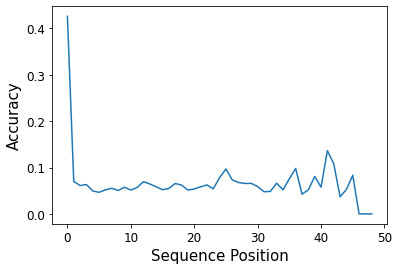

In [31]:
plt.plot(pos_accs)
#plt.plot(pos_accs_pep)
plt.xlabel('Sequence Position')
plt.ylabel('Accuracy')
plt.savefig(save_dir+'token_position_accuracy.png')
plt.show()

# Visualizing Model Memory

The memory of a model is analogous to the probability distribution of molecular embeddings that it has learned during training. A single molecular embedding is the size 128 vector at the center of the variational bottleneck. Each model has a built-in method for calculating and returning the model memory for a set of input structures, `calc_mems()`. ***(note - we plot the mean vector rather than the reparameterized vector so we can identify and analyze the meaningful latent dimensions)***

In [17]:
if model.model_type =='aae':
    mus, _, _ = model.calc_mems(data[:50_000], log=False, save=False) 
elif model.model_type == 'wae':
    mus, _, _ = model.calc_mems(data[:50_000], log=False, save=False) 
else:
    mems, mus, logvars = model.calc_mems(data[:], log=False, save=False) #subset size 1200*35=42000 would be ok

aae-128_peptide


Shannon information entropy

In [15]:
from transvae.tvae_util import *

In [16]:
#save the list of entropies for each latent dim
vae_entropy_mus = calc_entropy(mus)
save_df = pd.concat([save_df,pd.DataFrame({'mu_entropies':vae_entropy_mus})], axis=1)
if model.model_type != 'wae' and model.model_type!= 'aae': #these don't have a variational type bottleneck
    vae_entropy_mems  = calc_entropy(mems)
    save_df = pd.concat([save_df,pd.DataFrame({'mem_entropies':vae_entropy_mems})], axis=1)
    vae_entropy_logvars = calc_entropy(logvars)
    save_df = pd.concat([save_df,pd.DataFrame({'logvar_entropies':vae_entropy_logvars})], axis=1)

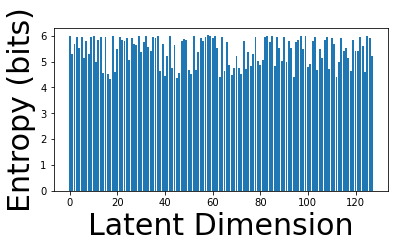

In [17]:
fig = plt.figure(figsize=(6,3))

plt.bar(range(len(vae_entropy_mus)), vae_entropy_mus)
plt.xlabel('Latent Dimension')
plt.ylabel('Entropy (bits)')
plt.savefig(save_dir+'mem_entropy')

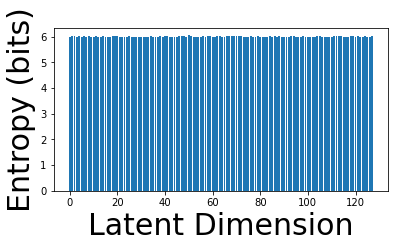

In [18]:
if model.model_type != 'wae' and model.model_type!= 'aae':
    fig = plt.figure(figsize=(6,3))
    plt.bar(range(len(vae_entropy_mems)), vae_entropy_mems)
    plt.xlabel('Latent Dimension')
    plt.ylabel('Entropy (bits)')
    plt.savefig(save_dir+'mu_entropy')

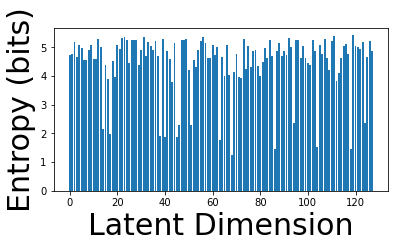

In [19]:
if model.model_type != 'wae' and model.model_type!= 'aae':
    fig = plt.figure(figsize=(6,3))
    plt.bar(range(len(vae_entropy_logvars)), vae_entropy_logvars)
    plt.xlabel('Latent Dimension')
    plt.ylabel('Entropy (bits)')
    plt.savefig(save_dir+'logvar_entropy')

We can see that some dimensions have significantly more information contained across the 25 samples than others and they correspond with the selective memory visualization shown above. We can sum the entropy of all dimensions to find the full model entropy. Again, note that we would need a larger sample size to converge the model entropy.

C:\Users\s_renaud\AppData\Local\Temp/ipykernel_10604/3633822751.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparency" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(save_dir+'mus.png', dpi=200, transparency=False)


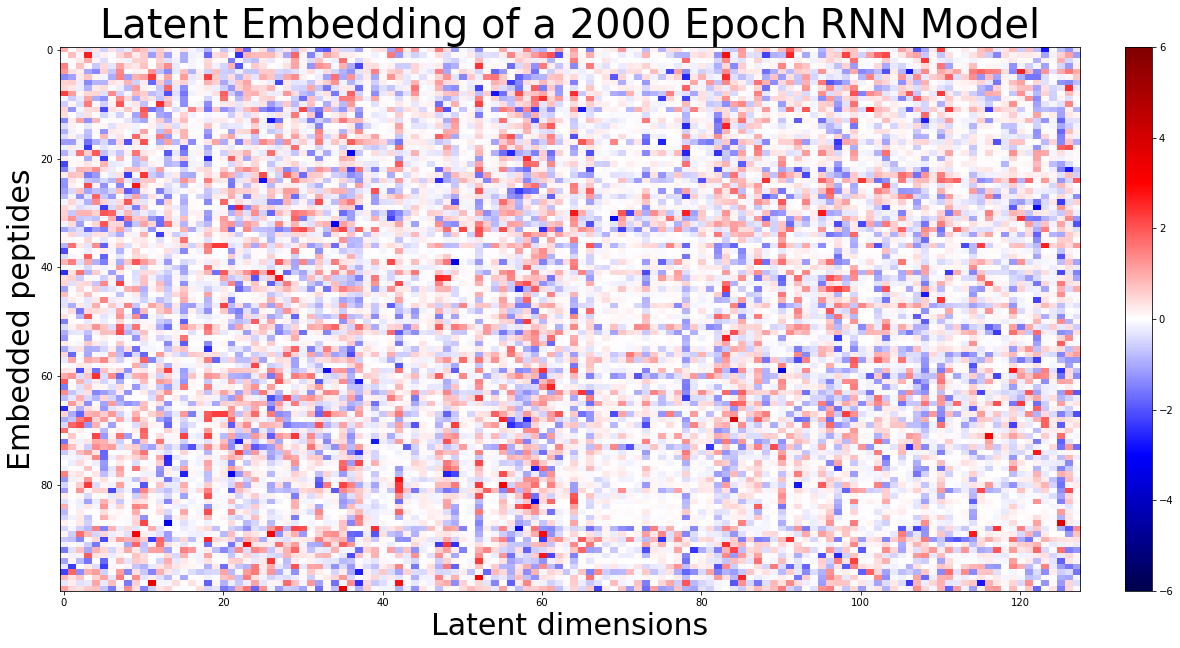

In [20]:
fig = plt.figure(figsize=(20,10))
plt.imshow(mus[:100], vmin=-6, vmax=6, aspect='auto', cmap='seismic')
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=40)     # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.xticks()
plt.yticks()
plt.ylabel("Embedded peptides", )
plt.xlabel("Latent dimensions")
plt.title('Latent Embedding of a 2000 Epoch RNN Model')
plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig(save_dir+'mus.png', dpi=200, transparency=False)
plt.show()

<h4>Evaluate the trustworthiness of the mapping from raw input data to latent space manifold

In [31]:
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import trustworthiness
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import plotly.express as px

true_prop_src = 'data\\peptides\\datasets\\uniprot_v2\\function_test.txt' #if property predictor load the true labels
#create random index and re-index ordered memory list creating n random sub-lists (ideally resulting in IID random lists)
random_idx = np.random.permutation(np.arange(stop=mus.shape[0]))
mus = mus[random_idx]
data = data[random_idx]

subsample_start=0
subsample_length=mus.shape[0] #this may change depending on batch size

#(for length based coloring): record all peptide lengths iterating through input
pep_lengths = []
for idx, pep in enumerate(data[subsample_start:(subsample_start+subsample_length)]):
    pep_lengths.append( len(pep[0]) )   
#(for function based coloring): pull function from csv with peptide functions
s_to_f =pd.read_csv(true_prop_src)    
function = s_to_f['peptides'][subsample_start:(subsample_start+subsample_length)]
function = function[random_idx] #account for random permutation

pca = PCA(n_components=5)
pca_batch =pca.fit_transform(X=mus[:])

#plot format dictionnaries
titles={'text':'{}'.format(model.model_type.replace("_"," ").upper()),
                      'x':0.5,'xanchor':'center','yanchor':'top','font_size':40}
general_fonts={'family':"Helvetica",'size':30,'color':"Black"}
colorbar_fmt={'title_font_size':30,'thickness':15,'ticks':'','title_text':'Lengths',
                           'ticklabelposition':"outside bottom"}

fig = px.scatter(pd.DataFrame({"PC1":pca_batch[:,0],"PC2":pca_batch[:,1], "lengths":pep_lengths}),
            symbol_sequence=['hexagon2'],x='PC1', y='PC2', color="lengths",
            color_continuous_scale='Jet',template='simple_white', opacity=0.9)
fig.update_traces(marker=dict(size=9))
fig.update_layout(title=titles,xaxis_title="PC1", yaxis_title="PC2",font=general_fonts)
fig.update_coloraxes(colorbar=colorbar_fmt)
fig.write_image(save_dir+'pca_length.png', width=900, height=600)

fig = px.scatter(pd.DataFrame({"PC1":pca_batch[:,0],"PC2":pca_batch[:,1], 
                                "Function":list(map(lambda itm: "AMP" if itm==1 else "NON-AMP",function))}),
                                x='PC1', y='PC2', color="Function",symbol_sequence=['x-thin-open','circle'],
                                template='simple_white',symbol='Function', opacity=0.8) 
fig.update_traces(marker=dict(size=9))
fig.update_layout(title=titles,xaxis_title="PC1",yaxis_title="PC2",font=general_fonts)
fig.write_image(save_dir+'pca_function.png', width=900, height=600)
# #create n subsamples and calculate silhouette score for each
# latent_mem_func_subsamples = []
# pca_func_subsamples = []
# n=20
# for s in range(n):
#     s_len = len(mus)//n #sample lengths
#     mem_func_sil = metrics.silhouette_score(mus[s_len*s:s_len*(s+1)], function[s_len*s:s_len*(s+1)], metric='euclidean')
#     latent_mem_func_subsamples.append(mem_func_sil)
#     XY = [i for i in zip(pca_batch[s_len*s:s_len*(s+1),0], pca_batch[s_len*s:s_len*(s+1),1])]
#     pca_func_sil = metrics.silhouette_score(XY, function[s_len*s:s_len*(s+1)], metric='euclidean')
#     pca_func_subsamples.append(pca_func_sil)
# save_df = pd.concat([save_df,pd.DataFrame({'latent_mem_func_silhouette':latent_mem_func_subsamples})], axis=1)
# save_df = pd.concat([save_df,pd.DataFrame({'pca_func_silhouette':pca_func_subsamples})], axis=1)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_*100, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.savefig(save_dir+'variance_explained.png')

<h4>Trustworthiness, Continuity, Steadiness, Cohesiveness </h4>

In [27]:
import coranking #coranking.readthedocs.io
from coranking.metrics import trustworthiness, continuity, LCMC
from transvae.snc import SNC #github.com/hj-n/steadiness-cohesiveness

trust_subsamples = []
cont_subsamples = []
lcmc_subsamples = []
steadiness_subsamples = []
cohesiveness_subsamples = []

n=35
parameter = { "k": 50,"alpha": 0.1 } #for steadiness and cohesiveness
for s in range(n):
    s_len = len(mus)//n #sample lengths
    Q = coranking.coranking_matrix(mus[s_len*s:s_len*(s+1)], pca_batch[s_len*s:s_len*(s+1)])
    trust_subsamples.append( np.mean(trustworthiness(Q, min_k=1, max_k=50)) )
    cont_subsamples.append( np.mean(continuity(Q, min_k=1, max_k=50)) )
    lcmc_subsamples.append( np.mean(LCMC(Q, min_k=1, max_k=50)) )
    print(n,trust_subsamples[s],cont_subsamples[s],lcmc_subsamples[s])
    
    metrics = SNC(raw=mus[s_len*s:s_len*(s+1)], emb=pca_batch[s_len*s:s_len*(s+1)], iteration=300, dist_parameter=parameter)
    metrics.fit() #solve for steadiness and cohesiveness
    steadiness_subsamples.append(metrics.steadiness())
    cohesiveness_subsamples.append(metrics.cohesiveness())
    print(metrics.steadiness(),metrics.cohesiveness())
    Q=0 #trying to free RAM
    metrics=0
    torch.cuda.empty_cache() #free allocated CUDA memory
    
save_df = pd.concat([save_df,pd.DataFrame({'latent_to_PCA_trustworthiness':trust_subsamples})], axis=1)
save_df = pd.concat([save_df,pd.DataFrame({'latent_to_PCA_continuity':cont_subsamples})], axis=1)
save_df = pd.concat([save_df,pd.DataFrame({'latent_to_PCA_lcmc':lcmc_subsamples})], axis=1)
save_df = pd.concat([save_df,pd.DataFrame({'latent_to_PCA_steadiness':steadiness_subsamples})], axis=1)
save_df = pd.concat([save_df,pd.DataFrame({'latent_to_PCA_cohesiveness':cohesiveness_subsamples})], axis=1)

KeyboardInterrupt: 

In [ ]:
save_df.to_csv(save_dir+"saved_info.csv", index=False)

<H3> New section dealing with sequence generation metrics and bootstrapping from the latent space

First generate 30_000 peptides

In [4]:
if model.model_type =='aae':
    test, _, _ = model.calc_mems(data[:100_000], log=False, save=False) 
elif model.model_type == 'wae':
    test, _, _ = model.calc_mems(data[:100_000], log=False, save=False) 
else:
    _, test, _ = model.calc_mems(data[:100_000], log=False, save=False)

aae-128_peptide


In [5]:
np.min(test), np.max(test)

(-13.194183, 10.485637)

In [6]:
rnd_seq_count = 1_000
rnd_latent_list=[] #generate N latent space vectors
for seq in range(rnd_seq_count):
    rnd_latent_list.append( np.array([random.uniform(-6,6) for i in range(model.params['d_latent'])]).astype(np.float32) )
print(len(rnd_latent_list))

1000


Turn latent vector into predicted token vector

In [7]:
model.params['BATCH_SIZE'] = 25
rnd_token_list=np.empty((rnd_seq_count,model.tgt_len)) #store N decoded latent vectors now in token(0-20) form max length 125
for batch in range(0,rnd_seq_count,model.params['BATCH_SIZE']):
    rnd_token_list[batch:batch+model.params['BATCH_SIZE']] =  model.greedy_decode(torch.tensor(rnd_latent_list[batch:batch+model.params['BATCH_SIZE']]).cuda()).cpu()

decoding sequences of max length  125 current position:  0


C:\Users\s_renaud\AppData\Local\Temp/ipykernel_22120/2032182237.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  rnd_token_list[batch:batch+model.params['BATCH_SIZE']] =  model.greedy_decode(torch.tensor(rnd_latent_list[batch:batch+model.params['BATCH_SIZE']]).cuda()).cpu()


decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 cu

 Turn token vector into propper amino acid characters

In [8]:
decoded_rnd_seqs = decode_mols(torch.tensor(rnd_token_list), model.params['ORG_DICT'])

<H4> Uniquenes Score (Min:0 -> Max:1)</H4>

In [9]:
z=1.96 #95% confidence interval
percent_unique = len(set(decoded_rnd_seqs)) / rnd_seq_count
unique_conf = z*math.sqrt(percent_unique*(1-percent_unique)/rnd_seq_count)
percent_unique, unique_conf

(0.997, 0.0033897235285491956)

In [10]:
df_gen_scores = {}
df_gen_scores.update({'percent_unique': percent_unique})
df_gen_scores.update({'unique_confidence':unique_conf})

<H4> Novelty: compare to the test set data </H4>

In [19]:
#sample N test set sequences randomly
shuffled_test = random.sample(data.tolist(),len(data))
shuffled_test = np.array(shuffled_test[:rnd_seq_count])
combined = np.concatenate(( shuffled_test,np.array(decoded_rnd_seqs).reshape(1000,1)) )
percent_novel = (len(set(combined.flatten().tolist()))-len(shuffled_test))/(rnd_seq_count)
novel_conf =  z*math.sqrt(percent_novel*(1-percent_novel)/(2*rnd_seq_count))
percent_novel, novel_conf
df_gen_scores.update({'percent_novel':percent_novel})
df_gen_scores.update({'novel_confidence':novel_conf})

<H4> Sequence Similarity</H4>

In [12]:
import Bio
from Bio import pairwise2
from Bio.Align import substitution_matrices

<p>scan through both the test set and generated set and do sequence alignment
<p><i>(currently it takes too long (~33sec.) to even do 1000 vs. 1000 comparisons so may only do a subset)

In [13]:
shuffled_test = shuffled_test.flatten().tolist()

In [14]:
similarity_score=[]
matrix = substitution_matrices.load("BLOSUM62")
for seq in shuffled_test[:10_000:100]: #grab 100 test set peptides
    for seq2 in decoded_rnd_seqs[::10]: #grab 100 of the 1000 random latent peptides
        similarity_score.append( pairwise2.align.globaldx(seq,seq2, matrix, score_only=True)/(len(seq)+len(seq2)) )

calculate average similarity score for all comparisons between test and generated sequences

In [15]:
df_gen_scores.update({'average_sequence_similarity': np.average(similarity_score)})
df_gen_scores.update({'std_on_similarity_score': np.std(similarity_score)})
np.average(similarity_score), np.std(similarity_score)

(0.36138985478521507, 0.20077701461743797)

In [16]:
df_gen_scores

{'percent_unique': 0.995,
 'unique_confidence': 0.004371722772546312,
 'percent_novel': 0.9975,
 'novel_confidence': 0.002188605720544452,
 'average_sequence_similarity': 0.36138985478521507,
 'std_on_similarity_score': 0.20077701461743797}

<H4>Section for sampling repeatedly in one region of the latent space and evaluating output

In [4]:
#GLFDIWKKWRWRR is an AMP in the test set. Use it as a reference point in the latent space
model.params['BATCH_SIZE'] = 1
if model.model_type =='aae':
    mus, _, _ = model.calc_mems(np.array([['GLFDIWKKWRWRR']], dtype='O'), log=False, save=False) 
elif model.model_type == 'wae':
    mus, _, _ = model.calc_mems(np.array([['GLFDIWKKWRWRR']], dtype='O'), log=False, save=False) 
else:
    mems, mus, logvars = model.calc_mems(np.array([['GLFDIWKKWRWRR']], dtype='O'), log=False, save=False) #subset size 1200*35=42000 would be ok

aae-128_peptide


<H4>Generate 10_000 128-dimensional samples for gaussian with mean 0 and create 10_000 points to decode near the original AMP

In [5]:
if model.model_type =='aae' or model.model_type =='wae':
    nearby_samples = np.random.normal(loc=0,scale=1,size=(100,1,model.params['d_latent'])).astype(np.float32)*0.4 + mus
else:
    nearby_samples = np.random.normal(loc=0,scale=1,size=(100,1,model.params['d_latent'])).astype(np.float32)*np.exp(0.5*logvars) + mus

In [6]:
rnd_seq_count=100
model.params['BATCH_SIZE'] = 50
rnd_token_list=np.empty((rnd_seq_count,model.tgt_len)) #store N decoded latent vectors now in token(0-20) form max length 125
for batch in range(0,rnd_seq_count,model.params['BATCH_SIZE']):
    rnd_token_list[batch:batch+model.params['BATCH_SIZE']] =  model.greedy_decode(torch.tensor(nearby_samples[batch:batch+model.params['BATCH_SIZE']]).squeeze().cuda()).cpu()

decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100


In [7]:
decoded_rnd_seqs = decode_mols(torch.tensor(rnd_token_list), model.params['ORG_DICT'])  

In [9]:
z=1.96 #95% confidence interval
amp_percent_unique = len(set(decoded_rnd_seqs))/len(decoded_rnd_seqs)
amp_unique_conf = z*math.sqrt(amp_percent_unique*(1-amp_percent_unique)/rnd_seq_count)
df_gen_scores.update({'amp_uniqueness': amp_percent_unique})
df_gen_scores.update({'amp_uniqueness_std': amp_unique_conf})

<h4>K'mer Count and Jaccard similarity </h4>
<p>select K value and compute jaccard similarity 

In [10]:
k=2
jac_scores = np.empty((len(list(set(decoded_rnd_seqs))),1))
jac_scores.shape
for i,decoded_seq in enumerate(list(set(decoded_rnd_seqs))):
    for j,seq in enumerate(np.array(['GLFDIWKKWRWRR'], dtype='O')):
        jac_scores[i,j] = (jaccard_similarity(build_kmers(seq,k), build_kmers(decoded_seq,k)))
# df_gen_scores.update({'amp_jac_score': np.average(jac_scores)})
# df_gen_scores.update({'amp_jac_score_std': np.std(jac_scores)})
np.average(jac_scores), np.std(jac_scores) 


(0.43797035911302673, 0.16861127927041167)

<H4>How many are predicted amps?

In [11]:
model.params['BATCH_SIZE'] = 2
reconstructed_seq, props = model.reconstruct(np.array([[seq] for seq in list(set(decoded_rnd_seqs))]), log=False, return_mems=False)    

aae-128_peptide
cuda
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
cuda
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
cuda
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
cuda
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
cuda
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
cuda
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
cuda
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current position:  100
cuda
decoding sequences of max length  125 current position:  0
decoding sequences of max length  125 current

<H4>Count the amps

In [22]:
sum(props.round()).item()/len(props)

0.33112582781456956

In [13]:
amp_percent_amp = sum(props.round()).item()/len(props)
amp_amp_conf = z*math.sqrt(amp_percent_amp*(1-amp_percent_amp)/len(props))
# df_gen_scores.update({'predicted_amps': amp_percent_amp})
# df_gen_scores.update({'predicted_amps_conf': amp_amp_conf})     

In [26]:
df = pd.DataFrame.from_dict([df_gen_scores])
pd.DataFrame.from_dict([df_gen_scores]).to_csv(save_dir+"generation_metrics.csv", index=False)

<H4> Now we want to plot all new samples using PCA so we need to perform PCA on all the test set mus and the extra generated ones

In [27]:
#GLFDIWKKWRWRR is an AMP in the test set. Use it as a reference point in the latent space
model.params['BATCH_SIZE'] = 200
if model.model_type =='aae':
    mus, _, _ = model.calc_mems(data[:20_000], log=False, save=False) 
elif model.model_type == 'wae':
    mus, _, _ = model.calc_mems(data[:20_000], log=False, save=False) 
else:
    mems, mus, logvars = model.calc_mems(data[:20_000], log=False, save=False)

aae-128_peptide


In [28]:
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import trustworthiness
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import plotly.express as px
import plotly.graph_objects as go

true_prop_src = 'data\\peptides\\datasets\\uniprot_v2\\function_test.txt'
model.params['BATCH_SIZE'] = 1
subsample_start=0
subsample_length=mus.shape[0] #this may change depending on batch size

#(for length based coloring): record all peptide lengths iterating through input
pep_lengths = []
for idx, pep in enumerate(data[subsample_start:(subsample_start+subsample_length)]):
    pep_lengths.append( len(pep[0]) )   
#(for function based coloring): pull function from csv with peptide functions
s_to_f =pd.read_csv(true_prop_src)    
function = s_to_f['peptides'][subsample_start:(subsample_start+subsample_length)]

pca = PCA(n_components=3)
pca_batch =pca.fit_transform(X=mus[:])
pca_generated = pca.transform(nearby_samples.squeeze())

if model.model_type =='aae' or model.model_type =='wae':
    amp_mus, _, _ = model.calc_mems(np.array([['GLFDIWKKWRWRR']], dtype='O'), log=False, save=False)
else:
    amp_mems, amp_mus, amp_logvars = model.calc_mems(np.array([['GLFDIWKKWRWRR']], dtype='O'), log=False, save=False)
pca_amp = pca.transform(amp_mus)

#plot format dictionnaries
titles={'text':'{}'.format(model.model_type.replace("_"," ").upper()),
                      'x':0.5,'xanchor':'center','yanchor':'top','font_size':40}
general_fonts={'family':"Helvetica",'size':30,'color':"Black"}
colorbar_fmt={'title_font_size':30,'thickness':15,'ticks':'','title_text':'Lengths',
                           'ticklabelposition':"outside bottom", 'showscale':'False'}

fig1 = px.scatter(pd.DataFrame({"PC1":pca_batch[:,0],"PC2":pca_batch[:,1], 
                                "Function":list(map(lambda itm: "AMP" if itm==1 else "NON-AMP",function))}),
                                x='PC1', y='PC2', color="Function",symbol_sequence=['x-thin-open','circle'],
                                template='simple_white',symbol='Function', opacity=0.3) 
fig2 = px.scatter(pd.DataFrame({"PC1":pca_generated[:,0],"PC2":pca_generated[:,1],
                                'color':["Generated" for i in pca_generated[:,0]],}),
                                x='PC1', y='PC2',color='color',labels='label',symbol_sequence=['asterisk-open'],
                                template='simple_white', opacity=0.9)
fig2.update_traces(marker=dict(color='red'))
fig3 = px.scatter(pd.DataFrame({"PC1":pca_amp[:,0],"PC2":pca_amp[:,1], 'color':['source AMP' for i in pca_amp[:,0]]}),
                                x='PC1', y='PC2',color='color',symbol_sequence=['cross'],
                                template='simple_white', opacity=1)
fig3.update_traces(marker=dict(size=12, color='black'))
fig1.update_traces(marker=dict(size=9))
fig2.update_traces(marker=dict(size=9))
fig = go.Figure(data= fig1.data+fig2.data+fig3.data)
fig.update_coloraxes(showscale=False)
fig.update_layout(title=titles,xaxis_title="PC1",yaxis_title="PC2",font=general_fonts)
fig.write_image(save_dir+'pca_function.png', width=1_000, height=700)

aae-128_peptide
